## Load Data

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, classification_report
from typing import Tuple
import warnings
warnings.filterwarnings("ignore")

In [ ]:
crypto_price_base_path = "/content/drive/MyDrive/CS526_DS_Group/Numeric Model/datasets/crypto prices/"
crypto_options = ["BTC", "ETH", "XRP", 'USDT']
def get_crypto_price_path(option, time_range="2022"):
    if option in crypto_options:
        if time_range == "all":
            return crypto_price_base_path + option + ".csv"
        else:
            return crypto_price_base_path + option + f"_{time_range}.csv"
    else:
        raise Exception("Invalid crypto options")

exogenous_data_path = "/content/drive/MyDrive/CS526_DS_Group/Numeric Model/datasets/combined_2022_data.csv"
crypto_price_path = get_crypto_price_path("BTC", time_range="2022")

In [ ]:
# Load Data
data = pd.read_csv(exogenous_data_path, index_col='date', parse_dates=True)
price = pd.read_csv(crypto_price_path, index_col='date', parse_dates=True)

train_size = 0.8
train_data_days = int(365 * train_size)
btc_price = price['close']
btc_price_train, btc_price_test = btc_price[:train_data_days], btc_price[train_data_days:]
exogenous_data = data[['TEU-ENG', 'fng_value']]  # 其他外生变量
exogenous_data_train, exogenous_data_test = exogenous_data[:train_data_days], exogenous_data[train_data_days:]

In [ ]:
# ADF Test: check a time series data is stationary or not
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("data is stationary")
    else:
        print("data is non-stationary，differencing is required")

def plot_acf_pacf(series):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, lags=40, ax=plt.gca())  # ACF graph
    plt.subplot(122)
    plot_pacf(series, lags=40, ax=plt.gca())  # PACF graph
    plt.show()
    print("-" * 120) # separator

# use BIC to determine p and q
def select_best_armax_order(series, exog, max_p=5, max_q=5):
    best_bic = np.inf
    best_order = None
    for p in range(0, max_p+1):
        for q in range(0, max_q+1):
            try:
                model = ARIMA(series, order=(p, 0, q), exog=exog)  # use stationary data
                results = model.fit()
                bic = results.bic  # get BIC value
                print(f"bic with p={p} and q={q}: {bic}")
                if bic < best_bic:
                    best_bic = bic
                    best_order = (p, q)
            except Exception as e:
                # Print error message for debugging
                print(f"Failed for p={p}, q={q}: {e}")
                continue

    return best_order

check data is stationary or not:
ADF Statistic: -1.3470999264849886
p-value: 0.6073582602762828
data is non-stationary，differencing is required


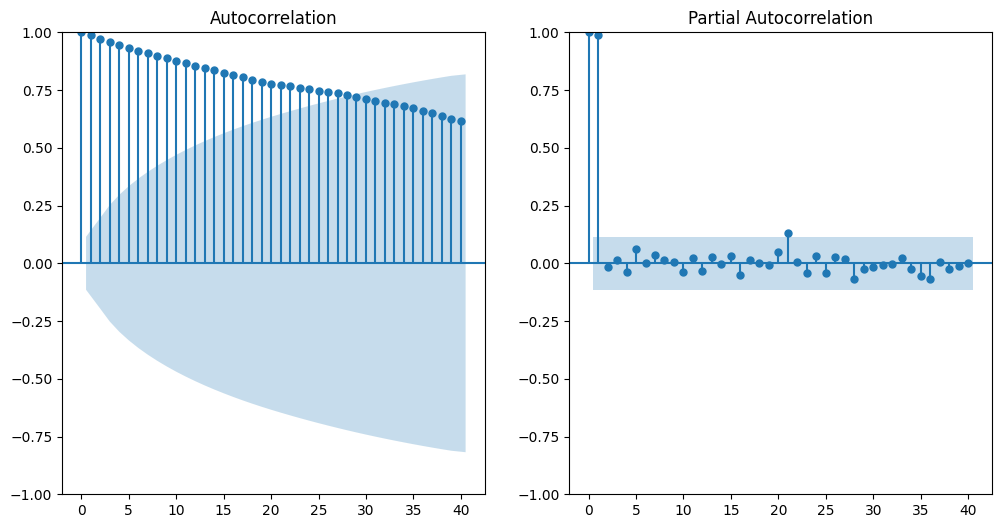

------------------------------------------------------------------------------------------------------------------------
检查一阶差分并检查平稳性：
ADF Statistic: -16.542379278202848
p-value: 1.9785091504472724e-29
data is stationary


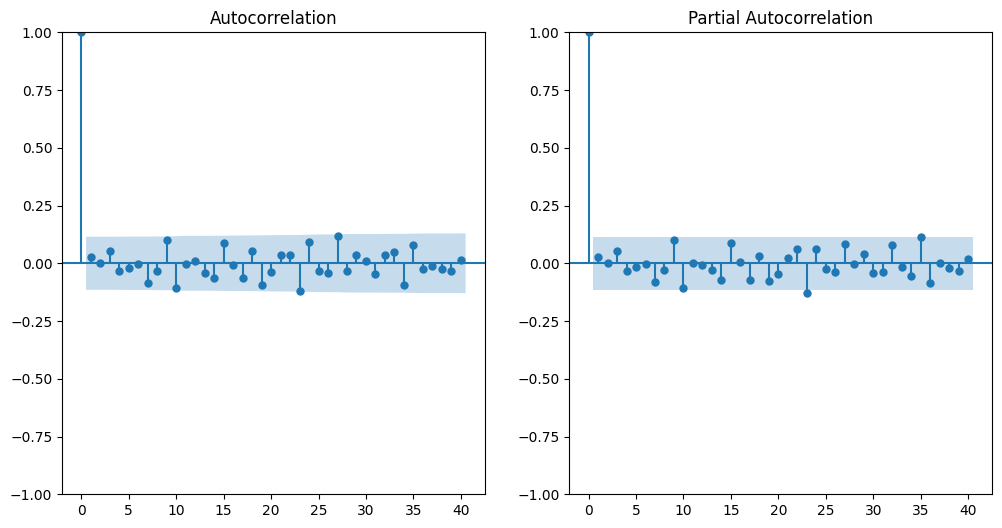

------------------------------------------------------------------------------------------------------------------------
检查二阶差分并检查平稳性：
ADF Statistic: -7.921081648270931
p-value: 3.722806269197493e-12
data is stationary


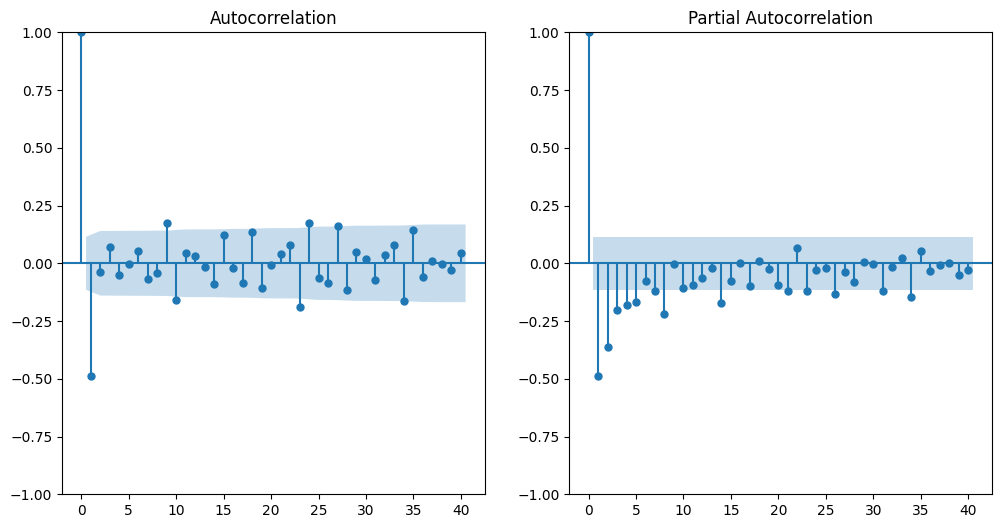

------------------------------------------------------------------------------------------------------------------------


In [ ]:
print("check data is stationary or not:")
check_stationarity(btc_price_train)  # check original data is stationary or not
plot_acf_pacf(btc_price_train)

# check first-order difference data is stationary or not
btc_price_diff = btc_price_train.diff().dropna()
print("check first-order difference data is stationary or not")
check_stationarity(btc_price_diff)
plot_acf_pacf(btc_price_diff)

# btc_price_diff_2 = btc_price_diff.diff().dropna()
# print("check second-order difference data is stationary or not")
# check_stationarity(btc_price_diff_2)
# plot_acf_pacf(btc_price_diff_2)

In [ ]:
# find optimal (p, q)
best_order = select_best_armax_order(btc_price_diff, exogenous_data_train[1:])
print(f"best_order: {best_order}")

bic with p=0 and q=0: 4920.074656537134
bic with p=0 and q=1: 4925.52814382432
bic with p=0 and q=2: 4931.192958813666
bic with p=0 and q=3: 4935.951546182418
bic with p=0 and q=4: 4941.482017500473
bic with p=0 and q=5: 4947.607895233145
bic with p=1 and q=0: 4925.520252192184
bic with p=1 and q=1: 4931.136476763278
bic with p=1 and q=2: 4935.986549241274
bic with p=1 and q=3: 4941.519091242894
bic with p=1 and q=4: 4943.709828932408
bic with p=1 and q=5: 4949.376169672135
bic with p=2 and q=0: 4931.193755309408
bic with p=2 and q=1: 4936.882174933076
bic with p=2 and q=2: 4941.590979424493
bic with p=2 and q=3: 4938.273203468444
bic with p=2 and q=4: 4952.824104593076
bic with p=2 and q=5: 4949.438353234024
bic with p=3 and q=0: 4936.022563746246
bic with p=3 and q=1: 4941.51287782489
bic with p=3 and q=2: 4938.429904869434
bic with p=3 and q=3: 4949.261789502983
bic with p=3 and q=4: 4946.90704152321
bic with p=3 and q=5: 4954.290997857822
bic with p=4 and q=0: 4941.363707809335
bic

Eval on train data: (p, d, q) = (0, 1, 0)
rmse: 2962.8351446332745
              precision    recall  f1-score   support

        Down       0.53      0.51      0.52       157
          Up       0.46      0.48      0.47       135

    accuracy                           0.50       292
   macro avg       0.50      0.50      0.50       292
weighted avg       0.50      0.50      0.50       292



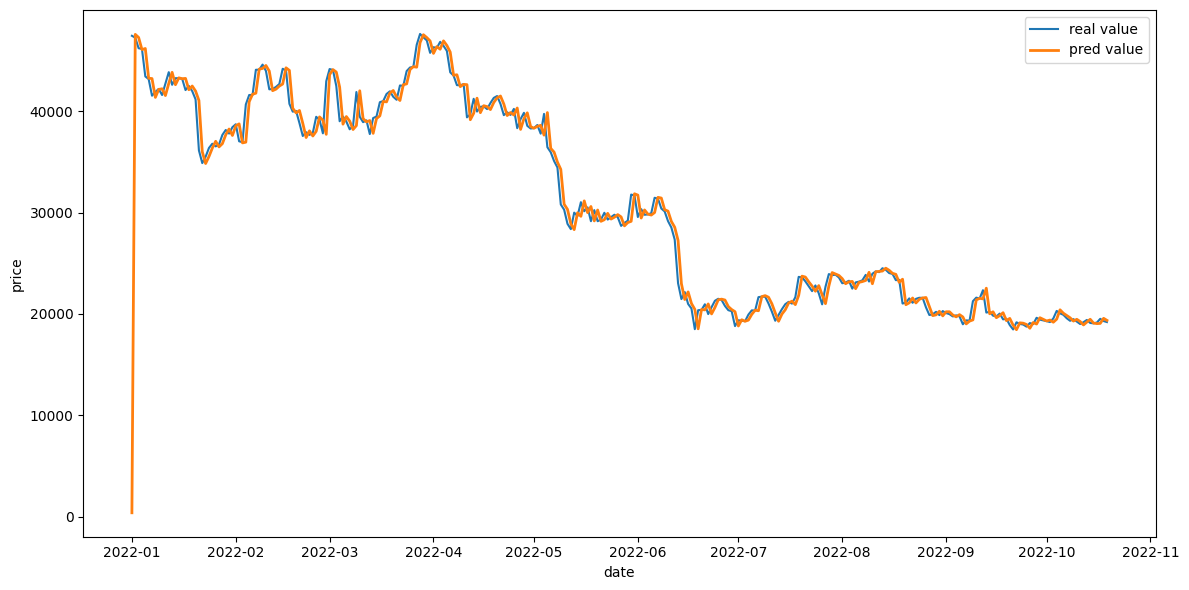

In [ ]:
p, q = best_order
d = 1
model = ARIMA(btc_price_train, order=(p, d, q), exog=exogenous_data_train).fit()
pred = model.predict(start=0, end=len(btc_price_train)-1, typ='levels')
true_dir = (btc_price_train.diff() > 0).astype(int)
pred_dir = (pred.diff() > 0).astype(int)
print(f"Eval on train data: (p, d, q) = ({p}, {d}, {q})")
print(f"rmse: {np.sqrt(mean_squared_error(btc_price_train, pred))}")
print(classification_report(true_dir, pred_dir, target_names=["Down", "Up"]))

plt.figure(figsize=(12, 6))
plt.plot(btc_price_train.index, btc_price_train.values, label='real value')
plt.plot(pred.index, pred.values, label='pred value', linewidth=2)
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def forecast_result(step: int, best_order: Tuple[int, int], d: int, price_data, exogenous_data, test_size: float, coin: str, calculate_returns=False, showPlot=False):
    p, q = best_order
    print(f"p: {p}, d: {d}, q: {q}")
    n = len(price_data)
    trainset_size = int(n * test_size)
    test_price = price_data[trainset_size:]

    pred_list = [] # store prediction results

    # prediction
    assert trainset_size + step <= n
    try:
        for t in range(trainset_size, n, step):
            step_eff = min(step, n - t)   # dynamic step
            x_train   = price_data.iloc[t - trainset_size:t]
            exog_train = exogenous_data.iloc[t - trainset_size:t]

            if calculate_returns == True:
                x_train = np.log(x_train).diff().dropna()
                exog_train = exog_train.shift(1).dropna()

            # fit ARMAX model
            model = ARIMA(x_train, order=(p, d, q), exog=exog_train,enforce_stationarity=False,
                enforce_invertibility=False).fit()

            # assume exogenous data to keep the same with the last data of training
            # to handle unknown future exogenous data
            last_exog = exog_train.iloc[[-1]].values
            future_index = price_data.index[t:t + step_eff]
            exog_fore = pd.DataFrame(
                np.repeat(last_exog, step_eff, axis=0),
                index=future_index,
                columns=exog_train.columns
            )

            # predict
            yhat = model.forecast(steps=step_eff, exog=exog_fore)

            if calculate_returns == True:
                P_start = price_data.iloc[t - 1]
                yhat = P_start * np.exp(yhat.clip(lower=-0.2, upper=0.2).cumsum())

            # add to prediction resutls
            pred_list.append(pd.Series(yhat.values, index=future_index))

        pred_series = pd.concat(pred_list).sort_index().rename('pred')
        true_series = test_price
        rmse = np.sqrt(((true_series - pred_series) ** 2).mean())
        print(f"RMSE: {rmse:.6f}")
        true_dir = (test_price.diff().dropna() > 0).astype(int)
        pred_dir = (pred_series.diff().dropna() > 0).astype(int)
        print(classification_report(true_dir, pred_dir, target_names=["Down", "Up"]))

        # Visualization
        if showPlot:
            plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data.values, label='real value')
            plt.plot(true_series.index, true_series.values, label='real value')
            plt.plot(pred_series.index, pred_series.values, label='pred value', linewidth=2)
            plt.title(f'ARIMAX price prediction on {coin} (training data size={trainset_size}, {step} day rolling origin, (p,d,q)=({p},{d},{q}), returns={calculate_returns})')
            plt.xlabel('date')
            plt.ylabel('price')
            plt.legend()
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"order ({p}, {d}, {q}) failed, {e}")


---
## ARIMA on Price

p: 1, d: 1, q: 1
RMSE: 772.536984
              precision    recall  f1-score   support

        Down       0.53      0.46      0.49        37
          Up       0.50      0.57      0.53        35

    accuracy                           0.51        72
   macro avg       0.52      0.52      0.51        72
weighted avg       0.52      0.51      0.51        72



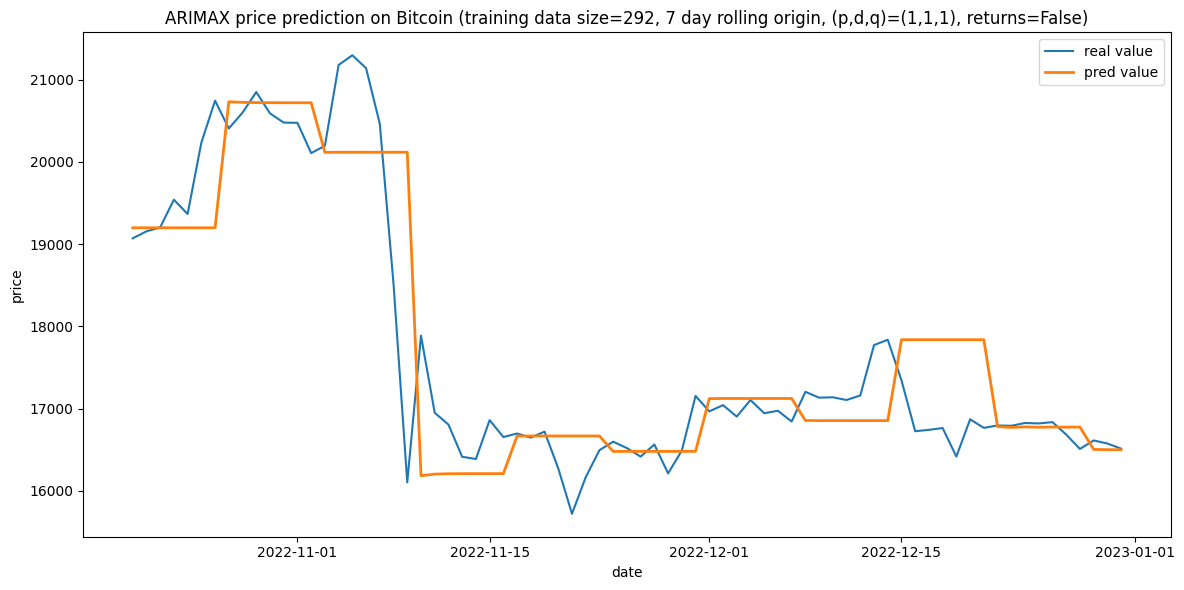

In [ ]:
forecast_result(step=7, best_order=(1, 1), d=1, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin", showPlot=True)

p: 1, d: 1, q: 1
RMSE: 530.078884
              precision    recall  f1-score   support

        Down       0.39      0.41      0.40        37
          Up       0.35      0.34      0.35        35

    accuracy                           0.38        72
   macro avg       0.37      0.37      0.37        72
weighted avg       0.37      0.38      0.37        72



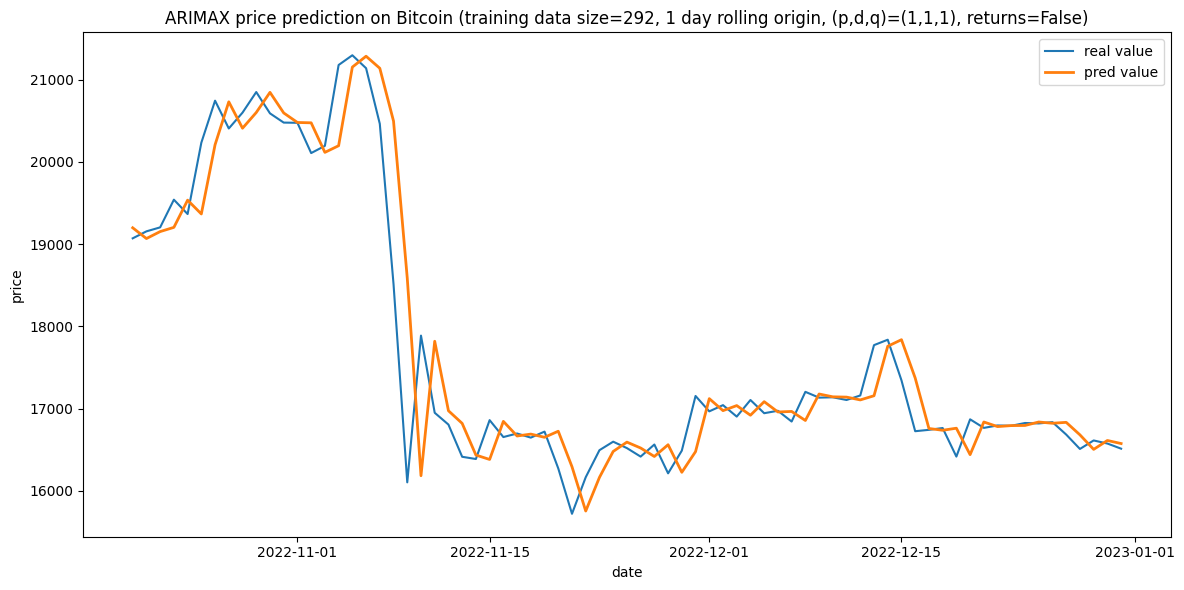

In [ ]:
forecast_result(step=1, best_order=(1, 1), d=1, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin", showPlot=True)

In [ ]:
for p in range(0, 9):
    for q in range(0, 9):
        forecast_result(step=7, best_order=(p, q), d=1, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin")

p: 0, d: 1, q: 0
RMSE: 781.991107
              precision    recall  f1-score   support

        Down       0.50      0.92      0.65        37
          Up       0.25      0.03      0.05        35

    accuracy                           0.49        72
   macro avg       0.38      0.47      0.35        72
weighted avg       0.38      0.49      0.36        72

p: 0, d: 1, q: 1
RMSE: 774.251799
              precision    recall  f1-score   support

        Down       0.50      0.92      0.65        37
          Up       0.25      0.03      0.05        35

    accuracy                           0.49        72
   macro avg       0.38      0.47      0.35        72
weighted avg       0.38      0.49      0.36        72

p: 0, d: 1, q: 2
RMSE: 776.116064
              precision    recall  f1-score   support

        Down       0.49      0.81      0.61        37
          Up       0.36      0.11      0.17        35

    accuracy                           0.47        72
   macro avg       0.43   

In [ ]:
forecast_result(step=73, best_order=best_order, d=1, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin")

p: 0, d: 1, q: 0
RMSE: 2184.141402
              precision    recall  f1-score   support

        Down       0.51      1.00      0.68        37
          Up       0.00      0.00      0.00        35

    accuracy                           0.51        72
   macro avg       0.26      0.50      0.34        72
weighted avg       0.26      0.51      0.35        72



In [ ]:
forecast_result(step=7, best_order=best_order, d=1, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin")

p: 0, d: 1, q: 0
RMSE: 781.991107
              precision    recall  f1-score   support

        Down       0.50      0.92      0.65        37
          Up       0.25      0.03      0.05        35

    accuracy                           0.49        72
   macro avg       0.38      0.47      0.35        72
weighted avg       0.38      0.49      0.36        72



In [ ]:
forecast_result(step=3, best_order=best_order, d=1, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin")

p: 0, d: 1, q: 0
RMSE: 811.596913
              precision    recall  f1-score   support

        Down       0.50      0.78      0.61        37
          Up       0.43      0.17      0.24        35

    accuracy                           0.49        72
   macro avg       0.46      0.48      0.43        72
weighted avg       0.47      0.49      0.43        72



In [ ]:
forecast_result(step=2, best_order=best_order, d=1, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin")

p: 0, d: 1, q: 0
RMSE: 568.415537
              precision    recall  f1-score   support

        Down       0.45      0.68      0.54        37
          Up       0.29      0.14      0.19        35

    accuracy                           0.42        72
   macro avg       0.37      0.41      0.37        72
weighted avg       0.38      0.42      0.37        72



In [ ]:
forecast_result(step=1, best_order=best_order, d=1, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin")

p: 0, d: 1, q: 0
RMSE: 528.865259
              precision    recall  f1-score   support

        Down       0.38      0.38      0.38        37
          Up       0.34      0.34      0.34        35

    accuracy                           0.36        72
   macro avg       0.36      0.36      0.36        72
weighted avg       0.36      0.36      0.36        72



## Prediction on Returns

In [ ]:
%%time

for p in range(0,9):
    for q in range(0, 9):
        forecast_result(step=7, best_order=(p, q), d=0, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin", calculate_returns=True)

p: 0, d: 0, q: 0
RMSE: 768.702101
              precision    recall  f1-score   support

        Down       0.56      0.76      0.64        37
          Up       0.59      0.37      0.46        35

    accuracy                           0.57        72
   macro avg       0.58      0.56      0.55        72
weighted avg       0.58      0.57      0.55        72

p: 0, d: 0, q: 1
RMSE: 777.423541
              precision    recall  f1-score   support

        Down       0.56      0.76      0.64        37
          Up       0.59      0.37      0.46        35

    accuracy                           0.57        72
   macro avg       0.58      0.56      0.55        72
weighted avg       0.58      0.57      0.55        72

p: 0, d: 0, q: 2
RMSE: 799.128294
              precision    recall  f1-score   support

        Down       0.59      0.81      0.68        37
          Up       0.67      0.40      0.50        35

    accuracy                           0.61        72
   macro avg       0.63   

In [ ]:
btc_returns_train = np.log(btc_price_train).diff().dropna()

,close
date,
2022-01-02,-0.003915
2022-01-03,-0.022299
2022-01-04,-0.001455
2022-01-05,-0.060633
2022-01-06,-0.006080
...,...
2022-10-15,-0.002012
2022-10-16,0.004103
2022-10-17,0.018980


ADF Statistic: -16.769595758558314
p-value: 1.2901945745711084e-29
data is stationary


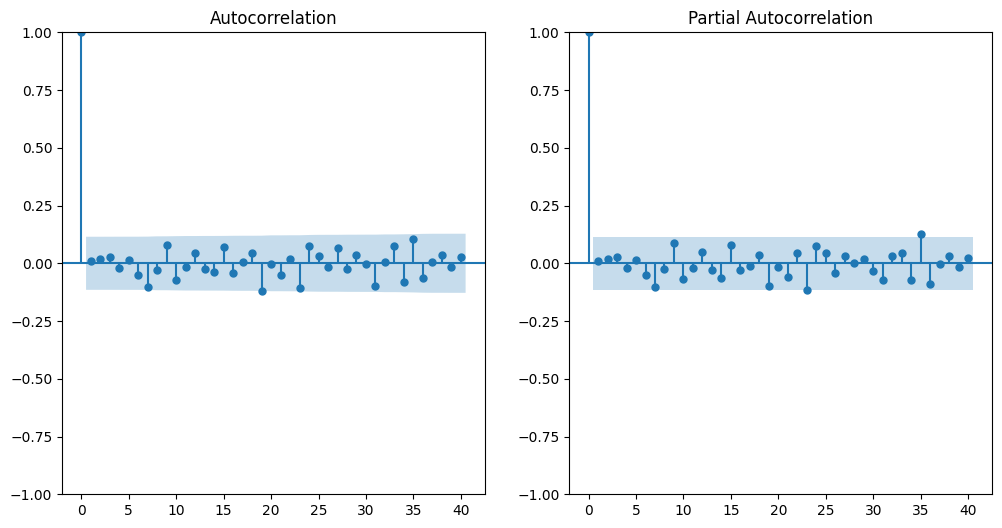

------------------------------------------------------------------------------------------------------------------------


In [ ]:
check_stationarity(btc_returns_train)
plot_acf_pacf(btc_returns_train)

In [ ]:
best_order = select_best_armax_order(btc_returns_train, exogenous_data_train.shift(1).dropna())
print(f"best_order: {best_order}")

bic with p=0 and q=0: -1109.8171488648397
bic with p=0 and q=1: -1104.1744303484338
bic with p=0 and q=2: -1098.6943899491537
bic with p=0 and q=3: -1093.3637560585457
bic with p=0 and q=4: -1087.6909114113157
bic with p=0 and q=5: -1082.3485634156484
bic with p=1 and q=0: -1104.1759948590825
bic with p=1 and q=1: -1098.5018391312778
bic with p=1 and q=2: -1093.0241155207889
bic with p=1 and q=3: -1087.4022625238088
bic with p=1 and q=4: -1082.017590771968
bic with p=1 and q=5: -1076.7390256980864
bic with p=2 and q=0: -1098.6990073376273
bic with p=2 and q=1: -1093.151492540352
bic with p=2 and q=2: -1087.3208494560654
bic with p=2 and q=3: -1082.0243645448948
bic with p=2 and q=4: -1077.1982821609135
bic with p=2 and q=5: -1074.3579278772027
bic with p=3 and q=0: -1093.3553416659136
bic with p=3 and q=1: -1087.6830830178496
bic with p=3 and q=2: -1082.0060643409854
bic with p=3 and q=3: -1076.3414322506194
bic with p=3 and q=4: -1071.9486660809966
bic with p=3 and q=5: -1069.78547950

In [ ]:
forecast_result(step=73, best_order=(0, 1), d=0, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, calculate_returns=True, coin="Bitcoin")

p: 0, d: 0, q: 1
RMSE: 2615.639442
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        37
          Up       0.49      1.00      0.65        35

    accuracy                           0.49        72
   macro avg       0.24      0.50      0.33        72
weighted avg       0.24      0.49      0.32        72



In [ ]:
forecast_result(step=7, best_order=(0, 1), d=0, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, calculate_returns=True, coin="Bitcoin")

p: 0, d: 0, q: 1
RMSE: 777.423541
              precision    recall  f1-score   support

        Down       0.56      0.76      0.64        37
          Up       0.59      0.37      0.46        35

    accuracy                           0.57        72
   macro avg       0.58      0.56      0.55        72
weighted avg       0.58      0.57      0.55        72



In [ ]:
forecast_result(step=7, best_order=(1, 1), d=0, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, calculate_returns=True, coin="Bitcoin")

p: 1, d: 0, q: 1
RMSE: 783.710757
              precision    recall  f1-score   support

        Down       0.51      0.54      0.53        37
          Up       0.48      0.46      0.47        35

    accuracy                           0.50        72
   macro avg       0.50      0.50      0.50        72
weighted avg       0.50      0.50      0.50        72



In [ ]:
forecast_result(step=7, best_order=(5, 5), d=0, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, calculate_returns=True, coin="Bitcoin")

p: 5, d: 0, q: 5
RMSE: 852.300025
              precision    recall  f1-score   support

        Down       0.51      0.54      0.53        37
          Up       0.48      0.46      0.47        35

    accuracy                           0.50        72
   macro avg       0.50      0.50      0.50        72
weighted avg       0.50      0.50      0.50        72



p: 2, d: 0, q: 3
RMSE: 835.272115
              precision    recall  f1-score   support

        Down       0.60      0.84      0.70        37
          Up       0.70      0.40      0.51        35

    accuracy                           0.62        72
   macro avg       0.65      0.62      0.60        72
weighted avg       0.65      0.62      0.61        72



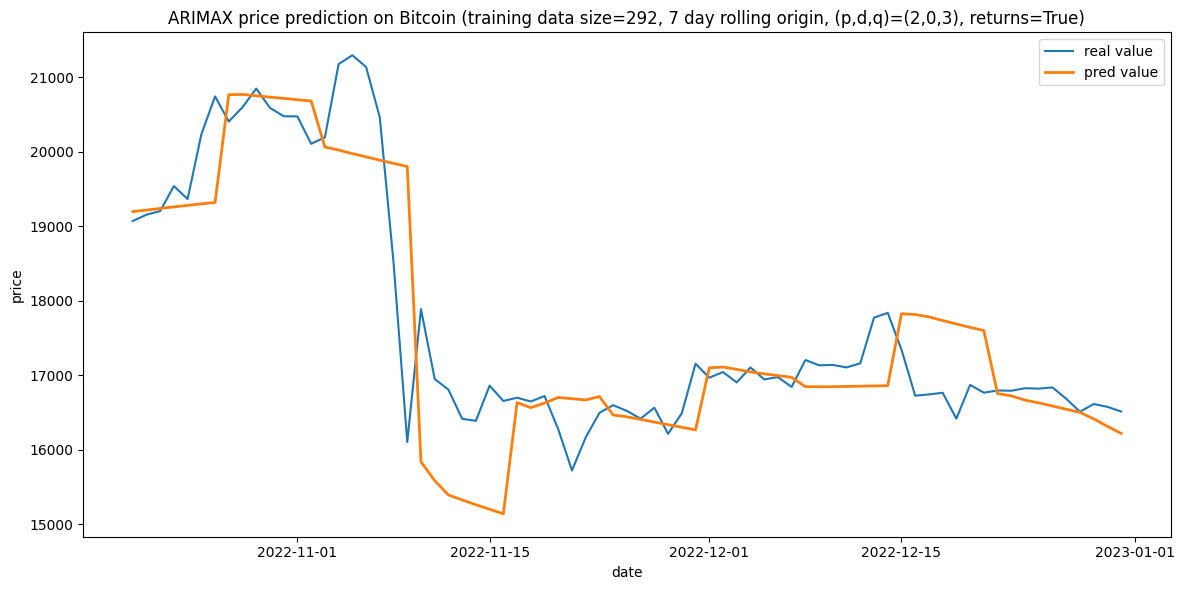

In [ ]:
forecast_result(step=7, best_order=(2, 3), d=0, price_data=btc_price, exogenous_data=exogenous_data, test_size=0.8, coin="Bitcoin", calculate_returns=True, showPlot=True)